In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import skimage.io as io
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import subprocess
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:

# get data from file
base_path = os.path.join('..', '..', 'data', 'Gauss_1.0_0.3')


# initialize lists
tracker_list = []
emcal_list = []
hcal_list = []
truth_list = []

for i in range(1000):  
    tracker_image_path = os.path.join(base_path, f'tracker_{i}.tiff')
    tracker = io.imread(tracker_image_path)
    tracker_list.append(tracker)

    emcal_image_path = os.path.join(base_path, f'emcal_{i}.tiff')
    emcal = io.imread(emcal_image_path)
    emcal_list.append(emcal)

    hcal_image_path = os.path.join(base_path, f'hcal_{i}.tiff')
    hcal = io.imread(hcal_image_path)
    hcal_list.append(hcal)
    
    truth_image_path = os.path.join(base_path, f'truth_{i}.tiff')
    truth = io.imread(truth_image_path)
    truth_list.append(truth)

# convert lists to numpy arrays
X_tracker = np.array(tracker_list).flatten()
X_emcal = np.array(emcal_list).flatten()
X_hcal = np.array(hcal_list).flatten()
Y_truth = np.array(truth_list).flatten()

X = np.array(list(zip(X_tracker, X_emcal, X_hcal,)))#进行zip操作：多个数组的元素按位置对齐组合在一起。然后进行list操作才能显示。不然他的值只是一个对应的地址。
X_train, X_test, y_train, y_test = train_test_split(X, Y_truth, test_size=0.3, random_state=42)

In [4]:
# Define the neural network model in PyTorch

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(3, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.hidden4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)  
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.hidden4(x))
        x = self.output(x)
        return x

model = MLP().to(device)# 使用gpu
criterion = nn.MSELoss()#定义损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)#使用Adam优化算法，将学习率设为0.001

# Convert numpy arrays to PyTorch tensors and move to the appropriate device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [5]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 560000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        if batch_idx % 10 == 0: 
            print(f'Epoch [{epoch + 1}/{n_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Summarize epoch
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

Epoch [1/20], Batch [0/4], Loss: 1.2755
Epoch [1/20], Loss: 1.1879
Epoch [2/20], Batch [0/4], Loss: 1.0300
Epoch [2/20], Loss: 0.9063
Epoch [3/20], Batch [0/4], Loss: 0.6950
Epoch [3/20], Loss: 0.5683
Epoch [4/20], Batch [0/4], Loss: 0.3949
Epoch [4/20], Loss: 0.3501
Epoch [5/20], Batch [0/4], Loss: 0.3002
Epoch [5/20], Loss: 0.2470
Epoch [6/20], Batch [0/4], Loss: 0.1559
Epoch [6/20], Loss: 0.1287
Epoch [7/20], Batch [0/4], Loss: 0.1065
Epoch [7/20], Loss: 0.1002
Epoch [8/20], Batch [0/4], Loss: 0.0801
Epoch [8/20], Loss: 0.0669
Epoch [9/20], Batch [0/4], Loss: 0.0527
Epoch [9/20], Loss: 0.0467
Epoch [10/20], Batch [0/4], Loss: 0.0325
Epoch [10/20], Loss: 0.0273
Epoch [11/20], Batch [0/4], Loss: 0.0242
Epoch [11/20], Loss: 0.0238
Epoch [12/20], Batch [0/4], Loss: 0.0217
Epoch [12/20], Loss: 0.0211
Epoch [13/20], Batch [0/4], Loss: 0.0203
Epoch [13/20], Loss: 0.0184
Epoch [14/20], Batch [0/4], Loss: 0.0148
Epoch [14/20], Loss: 0.0138
Epoch [15/20], Batch [0/4], Loss: 0.0125
Epoch [15/2

In [6]:
# Testing the model
# model.eval()
# with torch.no_grad():
#     y_pred_tensor = model(X_test_tensor)
#     y_pred = y_pred_tensor.cpu().numpy()
#     y_test_numpy = y_test_tensor.cpu().numpy()

# print(f'Model Score: {np.corrcoef(y_test_numpy.flatten(), y_pred.flatten())[0, 1]:.9f}')

# # Check GPU power usage
# if device.type == 'cuda':
#     gpu_power_usage = subprocess.check_output(
#         ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits']
#     ).decode('utf-8').strip()
#     print(f'GPU Power Usage: {gpu_power_usage} W')
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=560000, shuffle=False)

model.eval()
y_pred_list = []
y_test_list = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        outputs = model(data)
        y_pred_list.append(outputs.cpu().numpy())
        y_test_list.append(target.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_test_numpy = np.concatenate(y_test_list)

print(f'Model Score: {np.corrcoef(y_test_numpy.flatten(), y_pred.flatten())[0, 1]:.9f}')

# Check GPU power usage
if device.type == 'cuda':
    import subprocess
    gpu_power_usage = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits']
    ).decode('utf-8').strip()

Model Score: 0.995286316


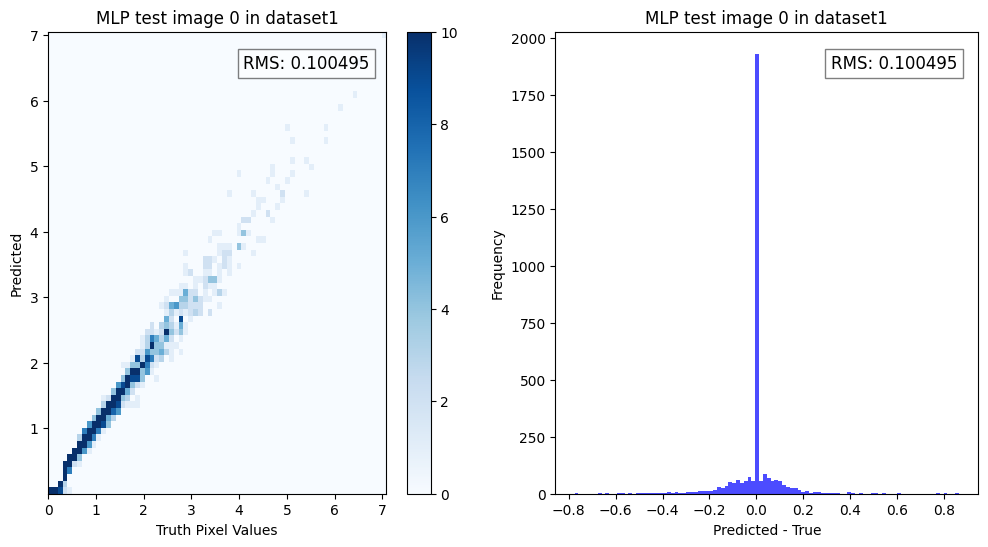

In [10]:
def image_plot(image_index):
    image_size = 56 * 56
    start_index = image_index * image_size
    end_index = start_index + image_size
    true_data = np.array(y_test[start_index:end_index]).flatten()
    predicted_data = np.array(y_pred[start_index:end_index]).flatten()

    # 计算误差指标（不去掉 true_data=0 的情况，用于 2D 图）
    error_2d = predicted_data - true_data
    # 计算 RMS 值（2D）
    rms_2d = np.sqrt(np.mean(error_2d**2))

    # 绘制2D直方图（保留 true_data=0 的情况）
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist2d(true_data, predicted_data, bins=(70, 70), cmap='Blues', vmin=0, vmax=10)
    plt.colorbar()
    plt.title(f'MLP test image {image_index} in dataset1')
    plt.xlabel('Truth Pixel Values')
    plt.ylabel('Predicted')
    plt.text(0.95, 0.95, f'RMS: {rms_2d:.6f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))


    # 计算 RMS 值（1D）
    rms_1d = rms_2d

    # 绘制1D直方图（去掉 true_data=0 的情况）
    plt.subplot(1, 2, 2)
    plt.hist(error_2d, bins=100, color='blue', alpha=0.7)
    plt.title(f'MLP test image {image_index} in dataset1')
    plt.xlabel('Predicted - True')
    plt.ylabel('Frequency')

    # 在图表上添加RMS值
    plt.text(0.95, 0.95, f'RMS: {rms_1d:.6f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()
image_plot(0)

In [8]:
sum =0
for i in range(100):
    image_index=i
    image_size = 56 * 56
    start_index = image_index * image_size
    end_index = start_index + image_size
    true_data = np.array(y_test[start_index:end_index]).flatten()
    predicted_data = np.array(y_pred[start_index:end_index]).flatten()
    error = predicted_data - true_data
    sum+=np.sqrt(np.mean(error**2))
sum/=100
print('average RMS in the first 500 test dataset:' ,sum)

average RMS in the first 500 test dataset: 0.09749380392233908
